This notebook performs AoI selection for the developmental LDM experiment. Features: 
* Visualization of raw eye-tracking data 
* Manual selection of AoI centers

In [2]:
%load_ext autoreload
%autoreload

In [3]:
# %matplotlib notebook
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
import scipy.io as io
import pandas as pd
from pandas import DataFrame, read_csv
from nivlink import Screen, Raw, align_to_aoi, compute_fixations, plot_heatmaps

import warnings
from scipy.stats import kde
import nivlink
import ipywidgets as wdg
from scipy.stats import iqr
print('Powered by NivLink' + str(nivlink.__version__))

Powered by NivLink0.2.5


### Define screen parameters and add AoIs.

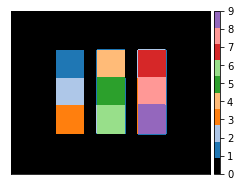

In [4]:
# Set screen metadata.
xdim, ydim, n_screens = 1279, 1023, 1 

# Initialize screen object.
info = Screen(xdim, ydim, n_screens)

# Recompute stimulus positions and spacing.
stim_size = 162
xcenter = np.floor(xdim/2); ycenter = np.floor(ydim/2);
dd = np.floor(stim_size/2);
xpos = [xcenter-3*dd-100, xcenter-dd, xcenter+100+dd];
ypos = [ycenter-3*dd-10, ycenter-dd, ycenter+dd+10];
xwidth = ywidth = stim_size
xpad = 10
ypad = 10

# Define and add areas of interest.
n_aois = 9
aois = np.empty((n_aois,2,2))

# Left column
aois[0] = np.matrix([[xpos[0]-xpad, ypos[0]-ypad], [xpos[0]+xwidth+xpad, ypos[0]+ywidth+ypad]])
aois[1] = np.matrix([[xpos[0]-xpad, ypos[1]-ypad], [xpos[0]+xwidth+xpad, ypos[1]+ywidth+ypad]])
aois[2] = np.matrix([[xpos[0]-xpad, ypos[2]-ypad], [xpos[0]+xwidth+xpad, ypos[2]+ywidth+ypad]])

# Middle column
aois[3] = np.matrix([[xpos[1]-xpad, ypos[0]-ypad], [xpos[1]+xwidth+xpad, ypos[0]+ywidth+ypad]])
aois[4] = np.matrix([[xpos[1]-xpad, ypos[1]-ypad], [xpos[1]+xwidth+xpad, ypos[1]+ywidth+ypad]])
aois[5] = np.matrix([[xpos[1]-xpad, ypos[2]-ypad], [xpos[1]+xwidth+xpad, ypos[2]+ywidth+ypad]])

# Right column
aois[6] = np.matrix([[xpos[2]-xpad, ypos[0]-ypad], [xpos[2]+xwidth+xpad, ypos[0]+ywidth+ypad]])
aois[7] = np.matrix([[xpos[2]-xpad, ypos[1]-ypad], [xpos[2]+xwidth+xpad, ypos[1]+ywidth+ypad]])
aois[8] = np.matrix([[xpos[2]-xpad, ypos[2]-ypad], [xpos[2]+xwidth+xpad, ypos[2]+ywidth+ypad]])

for a in range(0, n_aois):
    info.add_rectangle_aoi(aois[a,0,0], aois[a,1,0], aois[a,0,1], aois[a,1,1])
    
info.plot_aoi(0);

### Plot raw data for each subject.

In [5]:
all_subjects =  [23, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 53, 54, 
                 55, 57, 58, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71];

In [6]:
def load_subj_data(subj_id):
    
    et_data_dir = os.getcwd().strip('ldm-analysis') + 'RawData/'# this expects RawData to be one directory up from the analysis repo
    edf_path = et_data_dir + 'Sub' + str(subj_id) + 'ET.edf'
    # Read subject's data from edf file.
    data = Raw(edf_path)
    # Filter out only eye position.
    raw_pos_data = data.data[:,0,(0,1)]
    # Grab messages for epoching step.
    messages = data.messages 
 
    return raw_pos_data, messages

In [7]:
def get_run_onsets(messages): 
    """ Returns run onsets. 
        
        This function is specific to how the experiment code handles
        messages to the EDF file during the task.

    Parameters
    ----------
    messages: array, shape (n_times, 1) 
        Array containing messages from the NivLink Raw object.

    Returns
    -------
    run_onsets : array, shape (n_runs, 2)
        Run IDs and start indices.

    """

    n_messages = len(messages)
    run_onsets = np.empty((0,3), dtype = int)

    for m in np.arange(n_messages):
        
        this_message_index = messages[m][0]
        this_message = messages[m][1]
        
        ## We encountered a new run.
        if 'Run' in this_message:
             
            ## Get index of first XDAT 2 in this run. 
            ## This is specific to the LDM dataset
            ## because the first stim onset is not align with the Start Run message.   
            first_xdat2_message_index = messages[m+12][0]
            first_xdat2_message = messages[m+12][1]
            
            ## Initialize onset array for this run.
            this_run_onsets = np.empty((1,3), dtype = int); 
            this_run_onsets[:] = np.nan
            
            this_run_onsets[:,0] = int(this_message.strip('Run '))
            # this_run_onsets[:,1] = int(this_message_index) # actual run start message
            this_run_onsets[:,1] = int(first_xdat2_message_index)  # first XDAT2 in run
              
        ## Re-construct End Run message index by looking at the last trial in each run.
        ## Assumes we consistently had 40 trial per run as per LDM_Run4.m
        if 'Trial 40' in this_message:
            
            last_xdat1_message_index = messages[m+6][0]
            last_xdat1_message = messages[m+6][1]
            
            this_run_onsets[:,2] = int(last_xdat1_message_index)
            run_onsets = np.vstack((run_onsets,this_run_onsets))
            
    return run_onsets 

In [8]:
def mark_blocks(raw_pos_data, messages):

    ## Divide into runs for blockwise AoI customization.
    run_onsets = get_run_onsets(messages)
    n_runs, d = run_onsets.shape

    ## Make block index indicator.
    block_idx = np.zeros(len(raw_pos_data))
    for r in np.arange(n_runs):    
        block_start = run_onsets[r,1]
        block_end = run_onsets[r,2]    
        block_idx[block_start-1:block_end-1] = r+1

    ## Store in dataframe. 
    gaze_data = pd.DataFrame(data=raw_pos_data)
    gaze_data.columns = ['x','y'] 
    gaze_data['Block'] = block_idx.astype(int)

    return gaze_data

In [9]:
## Initialize colormap.
# Collect hex values from standard colormap.
cmap = cm.get_cmap('tab20', 20)

colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

colors = colors[:9]

# Add black.
colors = np.insert(colors, 0, 'k')

# Construct new colormap.
cmap = ListedColormap(colors)

subject: 23
subject: 26
subject: 27
subject: 28
subject: 29
subject: 30
subject: 31
subject: 33
subject: 34
subject: 35
subject: 36
subject: 37
subject: 38
subject: 39
subject: 40
subject: 41
subject: 42
subject: 43
subject: 44
subject: 45
subject: 46


<ipython-input-15-d9859acaa198>:65: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=(1279/my_dpi,1023/my_dpi));


subject: 47
subject: 49
subject: 53
subject: 54
subject: 55
subject: 57
subject: 58
subject: 60
subject: 61
subject: 62
subject: 63
subject: 66
subject: 67
subject: 68
subject: 69
subject: 70
subject: 71


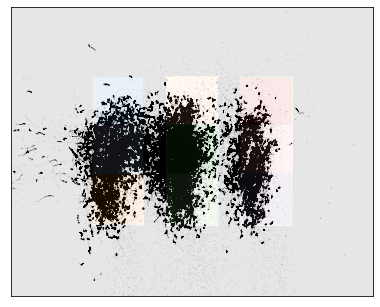

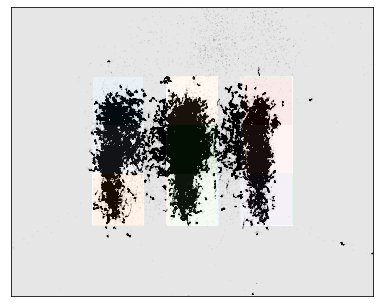

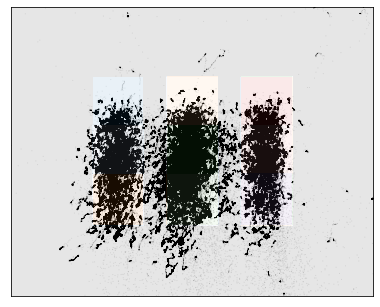

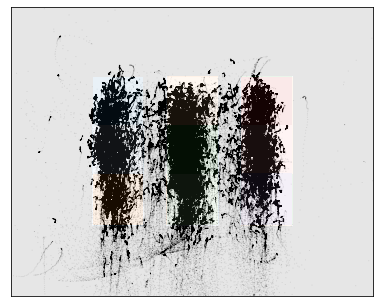

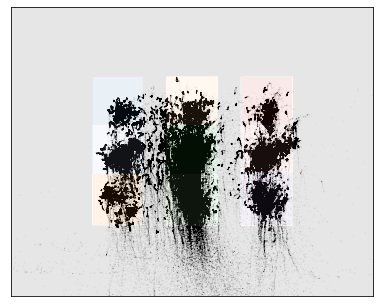

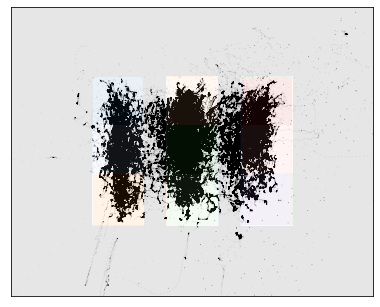

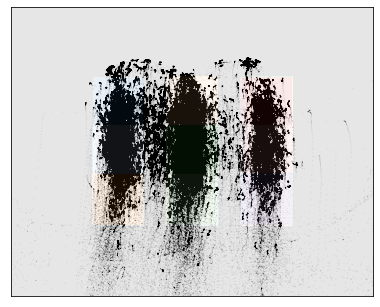

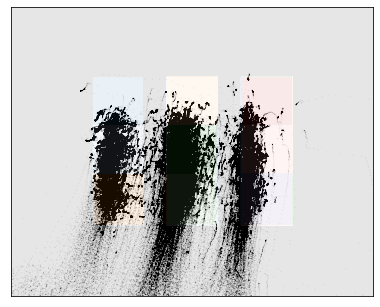

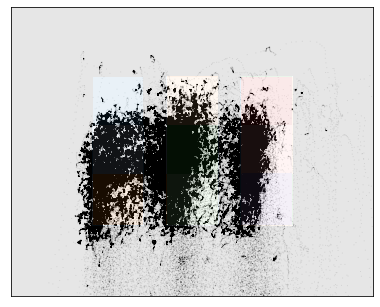

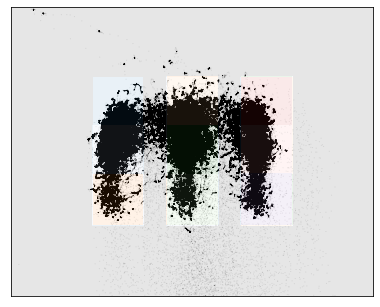

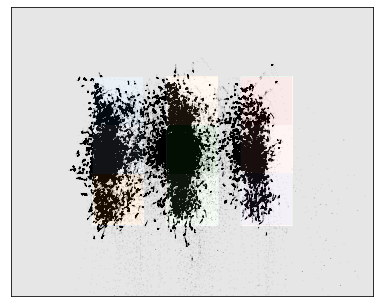

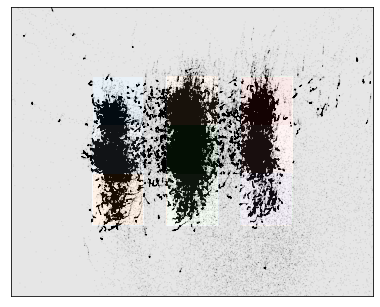

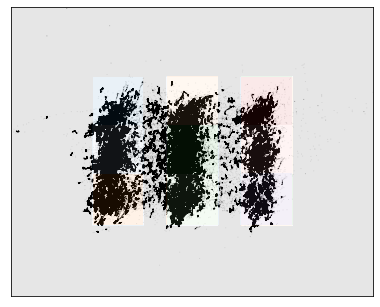

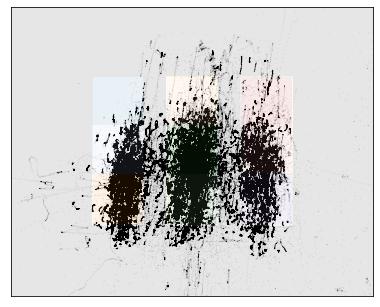

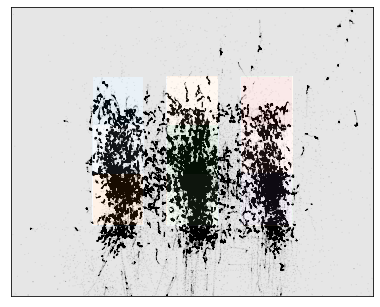

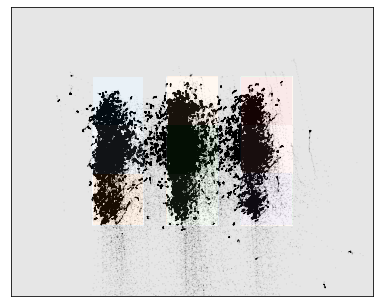

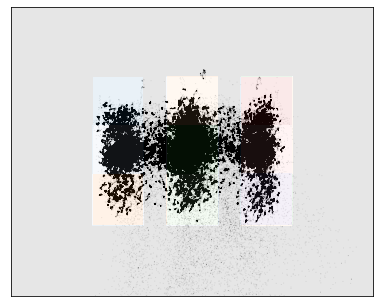

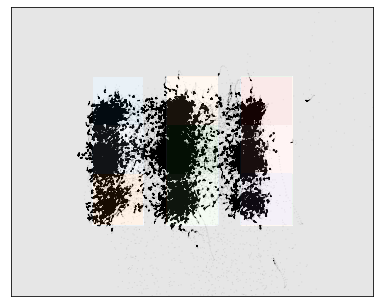

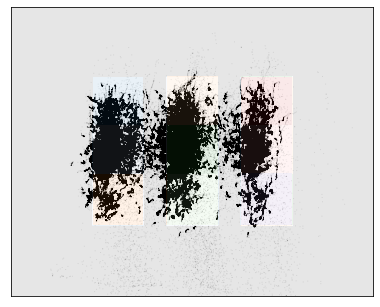

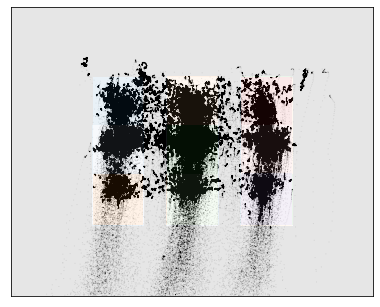

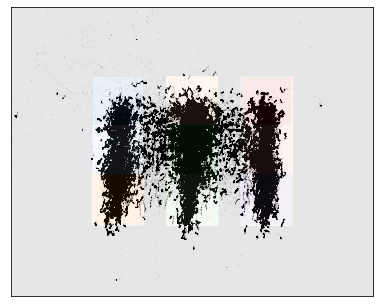

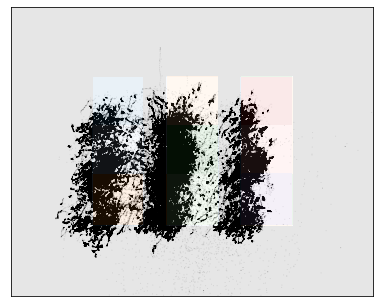

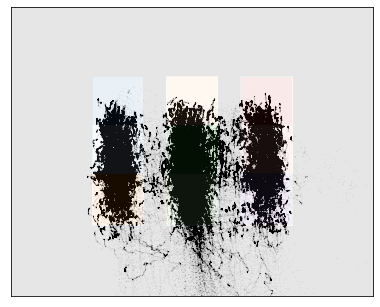

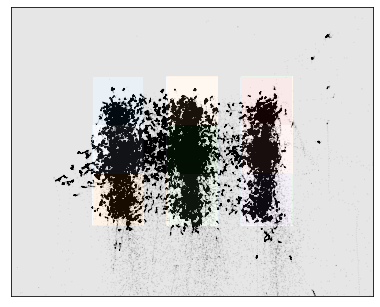

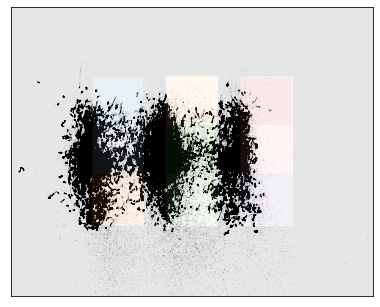

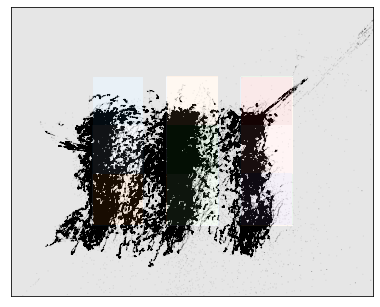

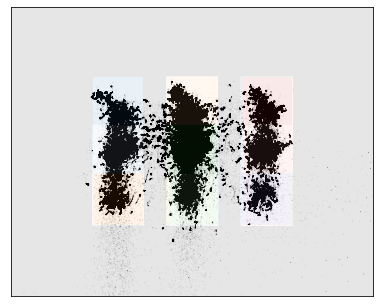

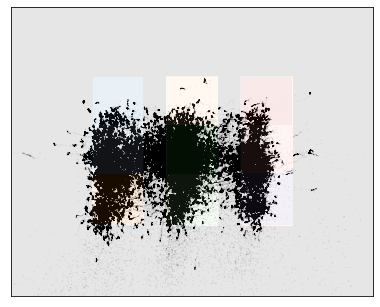

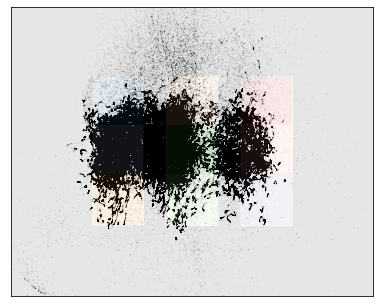

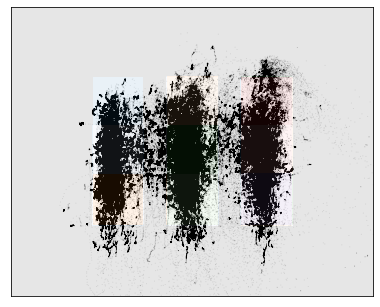

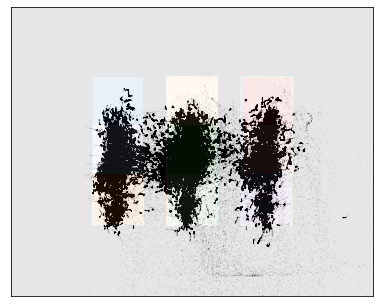

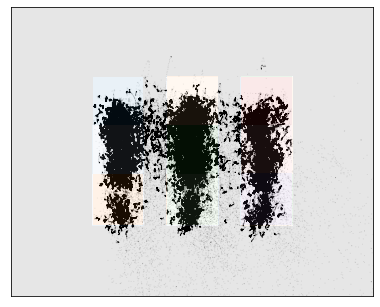

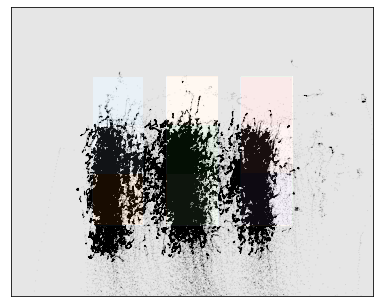

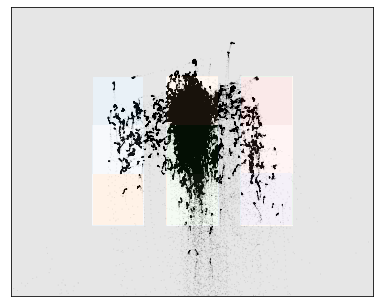

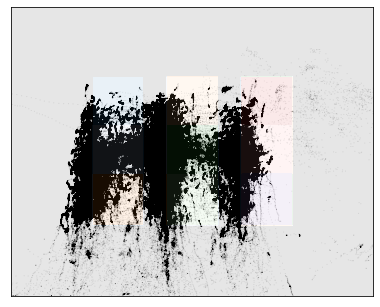

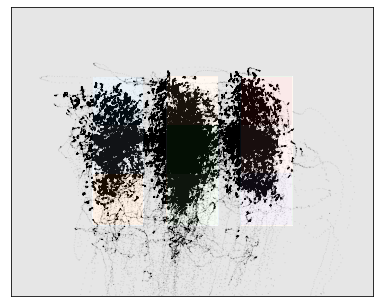

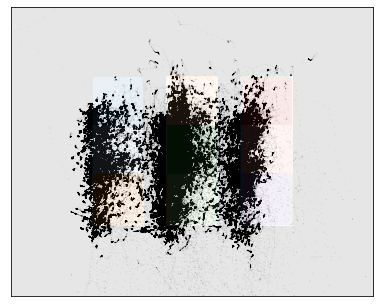

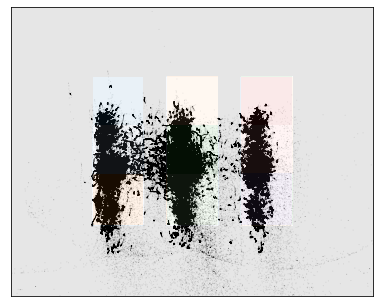

In [15]:
# Plot by block?
by_block = 0
my_dpi = 192 # correct for monitor in Meyer

for subj_id in all_subjects:
# for subj_id in [all_subjects[0]]:
    
    print('subject: ' + str(subj_id))
    
    raw_pos_data, messages = load_subj_data(subj_id)   
    gaze_data = mark_blocks(raw_pos_data, messages)
    
    if by_block: 

        for b in np.arange(10):

            block = b + 1
            print('block: ' + str(block))

            block_data = gaze_data.loc[gaze_data['Block'] == block][['x','y']].values
        
            ## Set some figure prelims.
            contrast = [0,0.5]

            ## Remove NaNs.
            mask = ~np.any(np.isnan(block_data),axis=1)
            x = block_data[mask,0]
            y = block_data[mask,1]
            x_y = np.column_stack([x,y])

            ## Compute 2D histogram in pixel space. 
            xedges = np.arange(0,info.xdim+1)
            yedges = np.arange(0,info.ydim+1)
            H, xedges, yedges = np.histogram2d(x, y,bins=(xedges, yedges))
            H = H.T

            ## Plot heatmap of blockwise raw eye-position with overlaid base AoIs.
            fig, ax = plt.subplots(1,1,figsize=(1279/my_dpi,1023/my_dpi));
            ax.imshow(H, interpolation='bilinear', cmap=cm.Greys, clim=(contrast[0], contrast[1]));
            ax.imshow(info.indices[:,:,0].T, alpha = 0.2, cmap = cmap)
            ax.set_xticks([]) 
            ax.set_yticks([])
            plt.savefig('labelcenters/Sub' + str(subj_id) + '_block_' + str(block) + '.png', format='png',dpi=my_dpi)
            
    else: 
        
        block_data = gaze_data.loc[gaze_data['Block'].isin(np.arange(10)+1)][['x','y']].values

        ## Set some figure prelims.
        contrast = [0,0.5]

        ## Remove NaNs.
        mask = ~np.any(np.isnan(block_data),axis=1)
        x = block_data[mask,0]
        y = block_data[mask,1]
        x_y = np.column_stack([x,y])

        ## Compute 2D histogram in pixel space. 
        xedges = np.arange(0,info.xdim+1)
        yedges = np.arange(0,info.ydim+1)
        H, xedges, yedges = np.histogram2d(x, y,bins=(xedges, yedges))
        H = H.T
        
        ## Plot heatmap of blockwise raw eye-position with overlaid base AoIs.
        fig, ax = plt.subplots(1,1,figsize=(1279/my_dpi,1023/my_dpi));
        ax.imshow(H, interpolation='bilinear', cmap=cm.Greys, clim=(contrast[0], contrast[1]));
        ax.imshow(info.indices[:,:,0].T, alpha = 0.1, cmap = cmap)
        ax.set_xticks([]) 
        ax.set_yticks([])
        plt.savefig('labelcenters/Sub' + str(subj_id) + '.png', format='png',dpi=my_dpi)